# Setup

This project requires Python 3.7 or above

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn >= 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TenserFlow >= 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons

## The Perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)

In [7]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='perceptron', penalty=None, learning_rate='constant', eta0=1,
                        random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y=None, xlabel=None, ylabel=None):
    a = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_ / model.coef_[0, 1]
    axes = [0, 5, 0, 2]
    x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_pred = per_clf.predict(X_new)
    zz = y_pred.reshape(x0.shape)
    custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

    plt.figure(figsize=(7, 3))
    plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
    plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
    plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
            linewidth=3)
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.legend(loc="lower right")
    plt.axis(axes)
    plt.show()

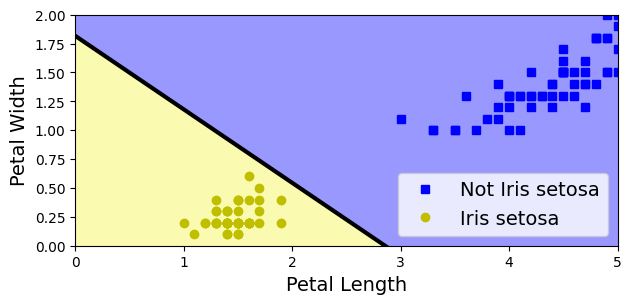

In [10]:
plot_decision_boundary(per_clf, X, y, 'Petal Length', 'Petal Width')

**Activation functions**

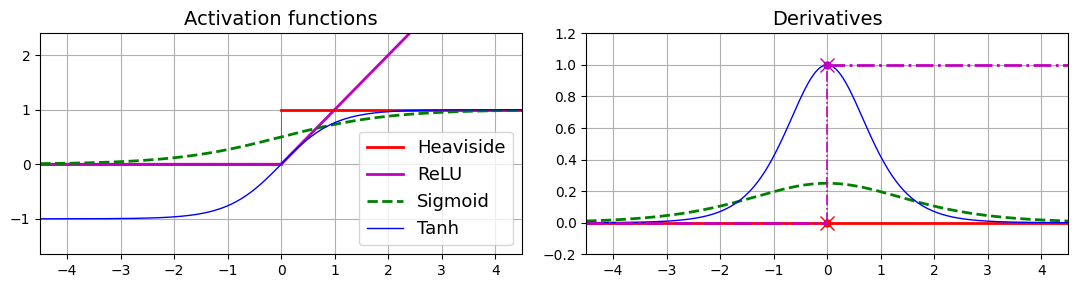

In [11]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, 
                                                              random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
                                                  random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.5053326657968725

## Classification MLPs

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier using the Sequential API
### Using Keras to load the dataset

In [14]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]

In [15]:
X_train.shape

(55000, 28, 28)

In [16]:
X_train.dtype

dtype('uint8')

In [17]:
X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

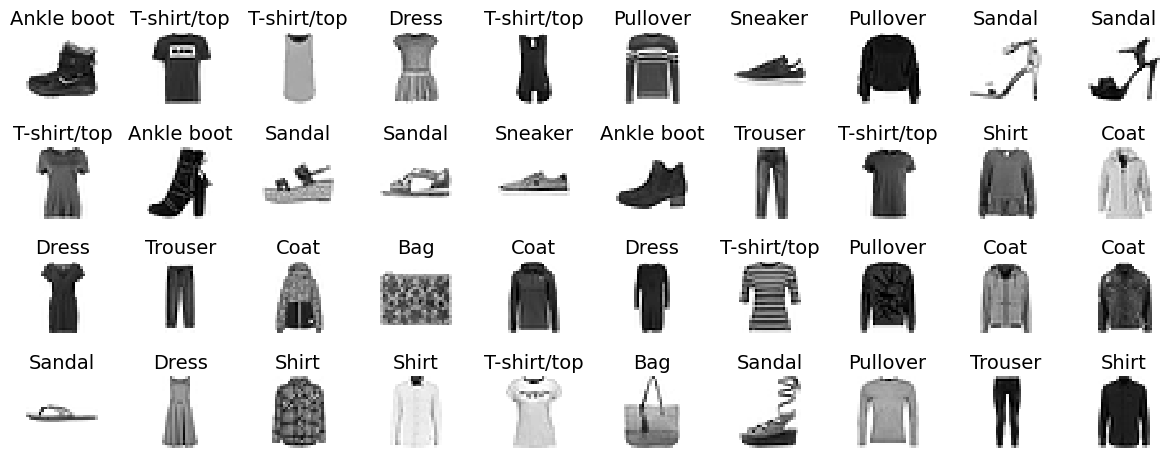

In [19]:
# extra code
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        idx = n_cols * row + col
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(X_train[idx], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[idx]])
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)

save_fig('fashion_mnist_plot')
plt.show()

### Creating the model using the Sequential API

In [20]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


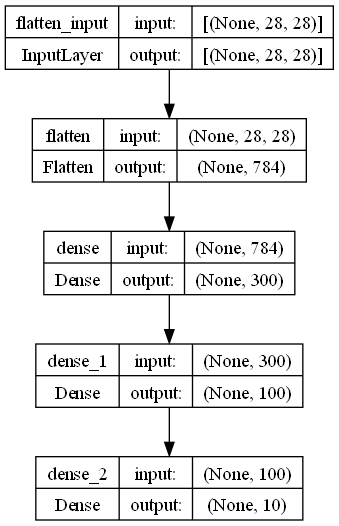

In [23]:
# another way to display the model's architecture
tf.keras.utils.plot_model(model, 'my_fashion_mnist_model.png', show_shapes=True)

In [24]:
model.layers

In [25]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [26]:
model.get_layer('dense') is hidden1

True

In [27]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.07010648, -0.07189578, -0.04359592, ...,  0.02122693,
         0.00905477, -0.04597747],
       [ 0.06849   ,  0.03829778, -0.04923196, ..., -0.01998861,
         0.05241515, -0.05473297],
       [ 0.06571572, -0.02101726, -0.04328166, ..., -0.0336121 ,
        -0.00971172, -0.05762763],
       ...,
       [-0.05741596, -0.06410734,  0.05031676, ..., -0.03753342,
         0.06126308,  0.05828856],
       [-0.05227356,  0.02239683, -0.05159505, ..., -0.04401845,
         0.00158713, -0.00042087],
       [ 0.0349973 , -0.05991647,  0.01065935, ..., -0.03525918,
         0.07293467, -0.05201973]], dtype=float32)

In [28]:
weights.shape

(784, 300)

In [29]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [30]:
biases.shape

(300,)

### Compiling the model

In [31]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [32]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0], dtype=int64)

If you want to convert sparse labels (i.e., class indices) to one-hot vector labels, use the `tf.keras.utils.to_categorical()` function. To go the other way round, use the `np.argmax()` function with axis=1.

### Training and evaluating the model

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30
1719/1719 [==============================] - 16s 8ms/step - loss: 0.7135 - accuracy: 0.7638 - val_loss: 0.5030 - val_accuracy: 0.8284
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4839 - accuracy: 0.8325 - val_loss: 0.4619 - val_accuracy: 0.8334
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4381 - accuracy: 0.8471 - val_loss: 0.4219 - val_accuracy: 0.8508
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4132 - accuracy: 0.8562 - val_loss: 0.3966 - val_accuracy: 0.8604
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3932 - accuracy: 0.8620 - val_loss: 0.3945 - val_accuracy: 0.8608
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3777 - accuracy: 0.8673 - val_loss: 0.3927 - val_accuracy: 0.8624
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3657 - accuracy: 0.8706 - val_loss: 0.3720 - val_accuracy

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

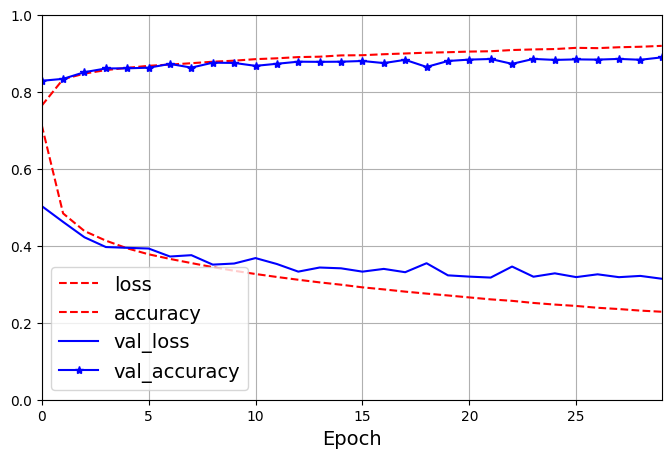

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*']
)
plt.legend(loc='lower left')
plt.show()

In [36]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3286 - accuracy: 0.8852


[0.3285856246948242, 0.885200023651123]

### Using the model to make predictions

In [37]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 89ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [38]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [39]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [40]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

## Building a Regression MLP using the Sequential API

In [41]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [42]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=['RootMeanSquaredError'])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 0.7853 - root_mean_squared_error: 0.8862 - val_loss: 0.5321 - val_root_mean_squared_error: 0.7294
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3705 - root_mean_squared_error: 0.6087 - val_loss: 1.8998 - val_root_mean_squared_error: 1.3783
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3648 - root_mean_squared_error: 0.6040 - val_loss: 0.3637 - val_root_mean_squared_error: 0.6030
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3369 - root_mean_squared_error: 0.5804 - val_loss: 1.0505 - val_root_mean_squared_error: 1.0249
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3295 - root_mean_squared_error: 0.5741 - val_loss: 0.4539 - val_root_mean_squared_error: 0.6737
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3183 - root_mean_squared_error: 0.5642 - val_loss: 1.1866 - val_

In [43]:
rmse_test

0.5275923013687134

In [44]:
y_pred

array([[0.34419936],
       [1.1828294 ],
       [4.9464917 ]], dtype=float32)

## Building Complex Models Using the Functional API

Not all neural networks are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network connects all or part of the inputs directly to the output layer.

In [45]:
# reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

*Wide & Deep neural network*

In [46]:
# the following 5 lines create all the layers we need to build the model
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

# next six lines use the above created layers to go from the input to the output
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

# NOTE: We are just telling Keras how it should connect the layers together; 
# no actual data is being processed yet, as the Input object is just a data specification.
# In other words, it's a symbolic input

# next line creates a Keras Model object by pointing to the input and the output
model = tf.keras.Model(inputs=[input_], outputs=[output])

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                              

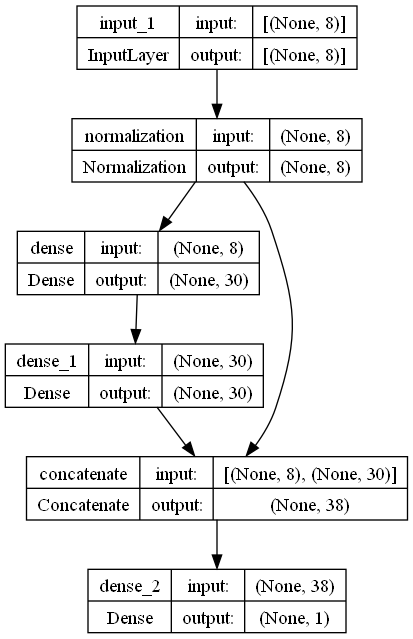

In [48]:
tf.keras.utils.plot_model(model, "California_housing_model.png", show_shapes=True)

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.1150 - root_mean_squared_error: 1.0559 - val_loss: 0.8793 - val_root_mean_squared_error: 0.9377
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4592 - root_mean_squared_error: 0.6777 - val_loss: 1.0078 - val_root_mean_squared_error: 1.0039
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4093 - root_mean_squared_error: 0.6397 - val_loss: 0.3688 - val_root_mean_squared_error: 0.6073
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3723 - root_mean_squared_error: 0.6102 - val_loss: 0.7143 - val_root_mean_squared_error: 0.8452
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3592 - root_mean_squared_error: 0.5993 - val_loss: 1.1005 - val_root_mean_squared_error: 1.0491
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3595 - root_mean_squared_error: 0.5996 - val_loss: 1.0572 - val_

In [50]:
tf.random.set_seed(42)

In [51]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.Concatenate()([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_val_wide, X_val_deep = X_val[:, :5], X_val[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_val_wide, X_val_deep), y_val))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.7787 - root_mean_squared_error: 1.3337 - val_loss: 0.9455 - val_root_mean_squared_error: 0.9724
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6504 - root_mean_squared_error: 0.8065 - val_loss: 2.0920 - val_root_mean_squared_error: 1.4464
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5332 - root_mean_squared_error: 0.7302 - val_loss: 0.6540 - val_root_mean_squared_error: 0.8087
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4509 - root_mean_squared_error: 0.6715 - val_loss: 0.4041 - val_root_mean_squared_error: 0.6357
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4086 - root_mean_squared_error: 0.6392 - val_loss: 0.8507 - val_root_mean_squared_error: 0.9223
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3903 - root_mean_squared_error: 0.6248 - val_loss: 1.6129 - val_

Instead of passing a tuple `(X_train_wide, X_train_deep)`, you can pass a dictionary `{"input_wide": X_train_wide, "input_deep": X_train_deep}`, if you set name="input_deep" when creating the inputs. This is highly recommended when there are many inputs, to clarify the code and avoid getting the order wrong.

Adding an auxiliary output for regularization

In [53]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [54]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.Concatenate()([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                        outputs=[output, aux_output])

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
                metrics=["RootMeanSquaredError"])

In [56]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val))
)

Epoch 1/20
363/363 [==============================] - 3s 6ms/step - loss: 1.6100 - dense_2_loss: 1.5000 - dense_3_loss: 2.6004 - dense_2_root_mean_squared_error: 1.2247 - dense_3_root_mean_squared_error: 1.6126 - val_loss: 1.6044 - val_dense_2_loss: 1.5967 - val_dense_3_loss: 1.6743 - val_dense_2_root_mean_squared_error: 1.2636 - val_dense_3_root_mean_squared_error: 1.2939
Epoch 2/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5775 - dense_2_loss: 0.5567 - dense_3_loss: 0.7646 - dense_2_root_mean_squared_error: 0.7461 - dense_3_root_mean_squared_error: 0.8744 - val_loss: 1.2927 - val_dense_2_loss: 1.2617 - val_dense_3_loss: 1.5717 - val_dense_2_root_mean_squared_error: 1.1233 - val_dense_3_root_mean_squared_error: 1.2537
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4792 - dense_2_loss: 0.4658 - dense_3_loss: 0.6004 - dense_2_root_mean_squared_error: 0.6825 - dense_3_root_mean_squared_error: 0.7749 - val_loss: 0.6127 - val_dense_2_loss

In [57]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 0s 3ms/step - loss: 0.3249 - dense_2_loss: 0.3194 - dense_3_loss: 0.3745 - dense_2_root_mean_squared_error: 0.5651 - dense_3_root_mean_squared_error: 0.6119


In [58]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 54ms/step


In [59]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 17ms/step


## Using the Subclassing API to Build Dynamic Models

With this approach, you subclass the `Model` class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. For example, creating an instance of the following `WideAndDeepModel` class gives us an equivalent model to the one we just built with the Functional API.

In [60]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to suppoty naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
    
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.Concatenate()([hidden2, norm_wide])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")


In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
                metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))


Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 1.4483 - output_1_loss: 1.4039 - output_2_loss: 1.8484 - output_1_root_mean_squared_error: 1.1848 - output_2_root_mean_squared_error: 1.3596 - val_loss: 1.0659 - val_output_1_loss: 0.9488 - val_output_2_loss: 2.1199 - val_output_1_root_mean_squared_error: 0.9741 - val_output_2_root_mean_squared_error: 1.4560
Epoch 2/10
363/363 [==============================] - 2s 4ms/step - loss: 0.5510 - output_1_loss: 0.5372 - output_2_loss: 0.6748 - output_1_root_mean_squared_error: 0.7329 - output_2_root_mean_squared_error: 0.8215 - val_loss: 1.0723 - val_output_1_loss: 1.0297 - val_output_2_loss: 1.4560 - val_output_1_root_mean_squared_error: 1.0147 - val_output_2_root_mean_squared_error: 1.2066
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4916 - output_1_loss: 0.4801 - output_2_loss: 0.5955 - output_1_root_mean_squared_error: 0.6929 - output_2_root_mean_squared_error: 0.7717 - val_loss: 0.473

## Saving and Restoring a Model

In [62]:
# delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [63]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


In [64]:
# show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model\assets
my_keras_model\keras_metadata.pb
my_keras_model\saved_model.pb
my_keras_model\variables
my_keras_model\variables\variables.data-00000-of-00001
my_keras_model\variables\variables.index


In [65]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 226ms/step


In [66]:
model.save_weights("my_weights")

In [67]:
model.load_weights("my_weights")

In [68]:
# show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


## Using Callbacks

In [69]:
shutil.rmtree("my_checkpoints", ignore_errors=True)

In [70]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val)),
    callbacks=[checkpoint_cb]
)

Epoch 1/10
363/363 [==============================] - 3s 7ms/step - loss: 0.3865 - output_1_loss: 0.3763 - output_2_loss: 0.4788 - output_1_root_mean_squared_error: 0.6134 - output_2_root_mean_squared_error: 0.6919 - val_loss: 0.6874 - val_output_1_loss: 0.7159 - val_output_2_loss: 0.4305 - val_output_1_root_mean_squared_error: 0.8461 - val_output_2_root_mean_squared_error: 0.6561
Epoch 2/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3637 - output_1_loss: 0.3538 - output_2_loss: 0.4520 - output_1_root_mean_squared_error: 0.5948 - output_2_root_mean_squared_error: 0.6723 - val_loss: 0.7858 - val_output_1_loss: 0.6902 - val_output_2_loss: 1.6462 - val_output_1_root_mean_squared_error: 0.8308 - val_output_2_root_mean_squared_error: 1.2830
Epoch 3/10
363/363 [==============================] - 2s 6ms/step - loss: 0.3648 - output_1_loss: 0.3550 - output_2_loss: 0.4525 - output_1_root_mean_squared_error: 0.5959 - output_2_root_mean_squared_error: 0.6727 - val_loss: 0.581

In [75]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val)),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3419 - output_1_loss: 0.3348 - output_2_loss: 0.4054 - output_1_root_mean_squared_error: 0.5787 - output_2_root_mean_squared_error: 0.6367 - val_loss: 1.0102 - val_output_1_loss: 1.0385 - val_output_2_loss: 0.7557 - val_output_1_root_mean_squared_error: 1.0191 - val_output_2_root_mean_squared_error: 0.8693
Epoch 2/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3450 - output_1_loss: 0.3381 - output_2_loss: 0.4066 - output_1_root_mean_squared_error: 0.5815 - output_2_root_mean_squared_error: 0.6376 - val_loss: 0.9430 - val_output_1_loss: 0.9275 - val_output_2_loss: 1.0820 - val_output_1_root_mean_squared_error: 0.9631 - val_output_2_root_mean_squared_error: 1.0402
Epoch 3/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3432 - output_1_loss: 0.3364 - output_2_loss: 0.4042 - output_1_root_mean_squared_error: 0.5800 - output_2_root_mean_squared_error: 0.6358 - val_loss: 0.

Custom callbacks

In [72]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [77]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val)),
    callbacks=[val_train_ratio_cb], verbose=0
)

Epoch=0, val/train=0.99
Epoch=1, val/train=1.10
Epoch=2, val/train=0.98
Epoch=3, val/train=0.98
Epoch=4, val/train=0.97
Epoch=5, val/train=1.12
Epoch=6, val/train=2.89
Epoch=7, val/train=6.99
Epoch=8, val/train=1.73
Epoch=9, val/train=1.39


## Using TensorBoard for Visualization

In [80]:
shutil.rmtree("my_logs", ignore_errors=True)

In [79]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [83]:
# builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [84]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_cb])

Epoch 1/20
363/363 [==============================] - 3s 7ms/step - loss: 1.5193 - root_mean_squared_error: 1.2326 - val_loss: 0.5694 - val_root_mean_squared_error: 0.7546
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4705 - root_mean_squared_error: 0.6859 - val_loss: 0.4757 - val_root_mean_squared_error: 0.6897
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3988 - root_mean_squared_error: 0.6315 - val_loss: 0.3725 - val_root_mean_squared_error: 0.6103
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3781 - root_mean_squared_error: 0.6149 - val_loss: 1.1507 - val_root_mean_squared_error: 1.0727
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3674 - root_mean_squared_error: 0.6061 - val_loss: 2.0999 - val_root_mean_squared_error: 1.4491
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3732 - root_mean_squared_error: 0.6109 - val_loss: 2.5549 - val_

In [85]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

If you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [88]:
if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

# Fine-Tuning Neural Network Hyperparameters

In [92]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]

In [93]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [94]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                            sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                    metrics=["accuracy"])
    return model

In [95]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashiion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                            validation_data=(X_val, y_val))

Trial 5 Complete [00h 00m 52s]
val_accuracy: 0.843999981880188

Best val_accuracy So Far: 0.8568000197410583
Total elapsed time: 00h 04m 27s
INFO:tensorflow:Oracle triggered exit


In [96]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [97]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values   # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [98]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8568000197410583


In [99]:
best_trial.metrics.get_last_value("val_accuracy")

0.8568000197410583

In [100]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3384 - accuracy: 0.8747
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3280 - accuracy: 0.8784
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3186 - accuracy: 0.8820
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3122 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3047 - accuracy: 0.8864
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2980 - accuracy: 0.8891
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2906 - accuracy: 0.8929
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2853 - accuracy: 0.8942
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2801 - accuracy: 0.8977
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.4102 